# Data Challenge: Happy Hotel

Step 1: importing and cleaning data

In [2]:
# import packages to be used

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
## loading data

os.getcwd()
os.chdir('C:/Users/Huajun/Desktop/Data challenge/')
file = 'hotel_happy_reviews.csv'
data = pd.read_csv(file)
data.info()

file2 = 'hotel_not_happy_reviews.csv'
data2 = pd.read_csv(file2)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26521 entries, 0 to 26520
Data columns (total 4 columns):
User_ID        26521 non-null object
Description    26521 non-null object
Is_Response    26521 non-null object
hotel_ID       26521 non-null int64
dtypes: int64(1), object(3)
memory usage: 828.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 4 columns):
User_ID        12411 non-null object
Description    12411 non-null object
Is_Response    12411 non-null object
hotel_ID       12411 non-null int64
dtypes: int64(1), object(3)
memory usage: 388.0+ KB


In [90]:
## Cleaning data
# check for unique values
print(len(data['User_ID'].unique()))
print(len(data['hotel_ID'].unique()))
print(len(data['Description'].unique()))

print(len(data2['User_ID'].unique()))
print(len(data2['hotel_ID'].unique()))
print(len(data2['Description'].unique()))

26521
10
26521
12411
10
12411


In [91]:
print(data['Is_Response'].value_counts())
print(data2['Is_Response'].value_counts())

happy    26521
Name: Is_Response, dtype: int64
not happy    12411
Name: Is_Response, dtype: int64


In [92]:
## appending two data files together

data = data.append(data2)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38932 entries, 0 to 12410
Data columns (total 4 columns):
User_ID        38932 non-null object
Description    38932 non-null object
Is_Response    38932 non-null object
hotel_ID       38932 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [7]:
# double check again for unique values

print(len(data['User_ID'].unique()))
print(len(data['hotel_ID'].unique()))
print(len(data['Description'].unique()))

38932
10
38932


In [8]:
print(data['Is_Response'].value_counts())

happy        26521
not happy    12411
Name: Is_Response, dtype: int64


Step 2: Identify topics within hotel reviews

In [34]:
# import packages to be used
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim
from gensim import corpora, models
from nltk.corpus import stopwords

In [10]:
data['Description'][:20]

0     Stayed here with husband and sons on the way t...
1     We had - rooms. One was very nice and clearly ...
2     My wife & I stayed in this glorious city a whi...
3     My boyfriend and I stayed at the Fairmont on a...
4     Steps off Times Square, nice rooms, stayed - n...
5     Me, the Wife and - kids stayed here on Valenti...
6     I highly recommend the Hawthorne Terrace as an...
7     I found the hotel clean and nicely located. Go...
8     Stayed at the Elan from --th to --th October a...
9     We stayed here for - nights and were really ha...
10    This is everything you could want from a hotel...
11    I really liked this hotel. The staff were wond...
12    My wife and spent - days there this month as a...
13    Took a girls trip to LA and had no idea where ...
14    Stayed with my girlfriend for a long weekend. ...
15    I have stayed here numerous times and never be...
16    I really liked this hotel alot. \r\nStaff was ...
17    We could easily have stayed here for longe

In [11]:
# preprocess texts in reviews
data['Description'] = data['Description'].map(lambda x: re.sub('[,\.!?&]', '', x))
data['Description'] = data['Description'].map(lambda x: x.lower())
data['Description'][:20]

0     stayed here with husband and sons on the way t...
1     we had - rooms one was very nice and clearly h...
2     my wife  i stayed in this glorious city a whil...
3     my boyfriend and i stayed at the fairmont on a...
4     steps off times square nice rooms stayed - nig...
5     me the wife and - kids stayed here on valentin...
6     i highly recommend the hawthorne terrace as an...
7     i found the hotel clean and nicely located goo...
8     stayed at the elan from --th to --th october a...
9     we stayed here for - nights and were really ha...
10    this is everything you could want from a hotel...
11    i really liked this hotel the staff were wonde...
12    my wife and spent - days there this month as a...
13    took a girls trip to la and had no idea where ...
14    stayed with my girlfriend for a long weekend \...
15    i have stayed here numerous times and never be...
16    i really liked this hotel alot \r\nstaff was e...
17    we could easily have stayed here for longe

In [27]:
# plotting the top 20 most common words within these reviews (not differentiating happy or not for now)

def plot_20_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

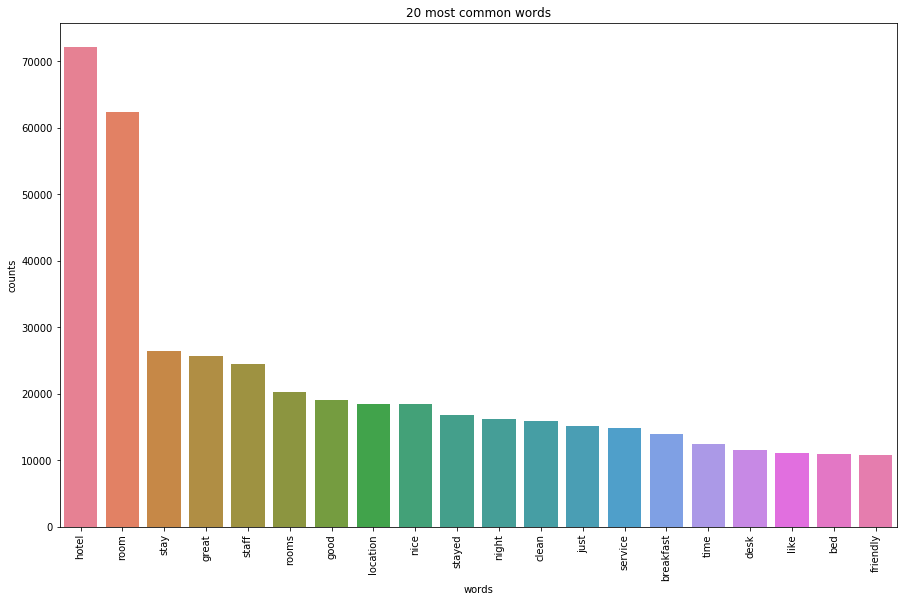

In [28]:
# remove stopwords and plot the top common words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(data['Description'])
plot_20_most_common_words(count_data, count_vectorizer)

In [43]:
import nltk
nltk.download('stopwords')
list_stopwords = stopwords.words('English')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Huajun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
list_stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [47]:
data['tokenized_des'] = data['Description'].apply(lambda x: x.split())
data['tokenized_des'][0]

0    [stayed, here, with, husband, and, sons, on, t...
0    [the, room, was, kind, of, clean, but, had, a,...
Name: tokenized_des, dtype: object

In [49]:
data['tokenized_des'] = data['tokenized_des'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in list_stopwords and len(token)>1])

data['tokenized_des'][0]

0    [stayed, husband, sons, way, alaska, cruise, l...
0    [room, kind, clean, strong, smell, dogs, gener...
Name: tokenized_des, dtype: object

In [50]:
tokens = data['tokenized_des'].to_list()
tokens[0]

['stayed',
 'husband',
 'sons',
 'way',
 'alaska',
 'cruise',
 'loved',
 'hotel',
 'great',
 'experience',
 'ask',
 'room',
 'north',
 'tower',
 'facing',
 'north',
 'west',
 'best',
 'views',
 'high',
 'floor',
 'stunning',
 'view',
 'needle',
 'city',
 'even',
 'cruise',
 'ships',
 'ordered',
 'room',
 'service',
 'dinner',
 'could',
 'enjoy',
 'perfect',
 'views',
 'room',
 'service',
 'dinners',
 'delicious',
 'perfect',
 'spot',
 'walk',
 'everywhere',
 'enjoy',
 'city',
 'almost',
 'heavenly',
 'beds',
 'heavenly']

In [51]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(token) for token in tokens]

In [54]:
num_topics = 10
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 2min 40s


In [55]:
lda_model.print_topics()

[(0,
  '0.018*"pool" + 0.016*"service" + 0.013*"business" + 0.012*"rooms" + 0.010*"property" + 0.010*"center" + 0.010*"good" + 0.010*"food" + 0.009*"area" + 0.009*"one"'),
 (1,
  '0.027*"great" + 0.025*"san" + 0.015*"view" + 0.014*"stay" + 0.011*"place" + 0.009*"francisco" + 0.009*"stayed" + 0.009*"really" + 0.008*"pool" + 0.008*"diego"'),
 (2,
  '0.065*"breakfast" + 0.026*"coffee" + 0.015*"inn" + 0.015*"good" + 0.015*"free" + 0.012*"clean" + 0.010*"staff" + 0.009*"morning" + 0.009*"continental" + 0.009*"buffet"'),
 (3,
  '0.019*"location" + 0.015*"walk" + 0.013*"square" + 0.013*"great" + 0.012*"street" + 0.011*"good" + 0.009*"walking" + 0.009*"times" + 0.009*"rooms" + 0.008*"clean"'),
 (4,
  '0.023*"bathroom" + 0.022*"bed" + 0.018*"nice" + 0.016*"small" + 0.013*"tv" + 0.013*"shower" + 0.012*"lobby" + 0.010*"area" + 0.009*"floor" + 0.009*"large"'),
 (5,
  '0.030*"desk" + 0.029*"us" + 0.028*"front" + 0.019*"staff" + 0.013*"stay" + 0.013*"service" + 0.010*"went" + 0.009*"manager" + 0.008

In [57]:
lda_model[corpus[0]]

# first corpus description is 93.6% about topic 1 and 6.3% about topic 3

[(1, 0.9357082), (3, 0.062555656)]

Step 3: Allocation of topics in all descriptions/reviews

In [59]:
%%time
topics = [lda_model[corpus[i]] for i in range(len(data))]
len(topics)

Wall time: 33.8 s


38932

In [67]:
# define function to create df where topics as columns and rows as input document

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(2, 0.03853655432967504), (5, 0.09130117862212643), (8, 0.8692868808484044)], 10)

,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,0.0385366,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [62]:
# create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [63]:
document_topic.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.935692,0.000000,0.062572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.033657,0.047644,0.000000,0.134871,0.782669,0.000000,0.000000,0.000000
2,0.0,0.317652,0.000000,0.307296,0.000000,0.040994,0.081804,0.000000,0.251541,0.000000
3,0.0,0.416078,0.057316,0.000000,0.117221,0.298880,0.000000,0.000000,0.109442,0.000000
4,0.0,0.000000,0.000000,0.671761,0.000000,0.000000,0.000000,0.000000,0.320318,0.000000
5,0.0,0.684274,0.000000,0.000000,0.000000,0.047181,0.266549,0.000000,0.000000,0.000000
6,0.0,0.000000,0.094862,0.386681,0.000000,0.000000,0.331176,0.000000,0.185920,0.000000
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.996413,0.000000,0.000000,0.000000
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.025408,0.307622,0.579083,0.086725
9,0.0,0.021548,0.279584,0.142681,0.000000,0.031817,0.393010,0.093773,0.000000,0.030788


In [68]:
document_topic.shape

(38932, 10)

In [69]:
data.head(10)

,User_ID,Description,Is_Response,hotel_ID,tokenized_des
0,id10329,stayed here with husband and sons on the way t...,happy,8,"[stayed, husband, sons, way, alaska, cruise, l..."
1,id10331,we had - rooms one was very nice and clearly h...,happy,3,"[rooms, one, nice, clearly, updated, recently,..."
2,id10333,my wife i stayed in this glorious city a whil...,happy,3,"[wife, stayed, glorious, city, back, sf, expen..."
3,id10334,my boyfriend and i stayed at the fairmont on a...,happy,7,"[boyfriend, stayed, fairmont, recent, trip, sa..."
4,id10336,steps off times square nice rooms stayed - nig...,happy,3,"[steps, times, square, nice, rooms, stayed, ni..."
5,id10337,me the wife and - kids stayed here on valentin...,happy,7,"[wife, kids, stayed, weekend, really, nice, ho..."
6,id10339,i highly recommend the hawthorne terrace as an...,happy,8,"[highly, recommend, hawthorne, terrace, afford..."
7,id10340,i found the hotel clean and nicely located goo...,happy,3,"[found, hotel, clean, nicely, located, good, f..."
8,id10341,stayed at the elan from --th to --th october a...,happy,1,"[stayed, elan, october, liked, much, returned,..."
9,id10344,we stayed here for - nights and were really ha...,happy,5,"[stayed, nights, really, happy, located, walk,..."


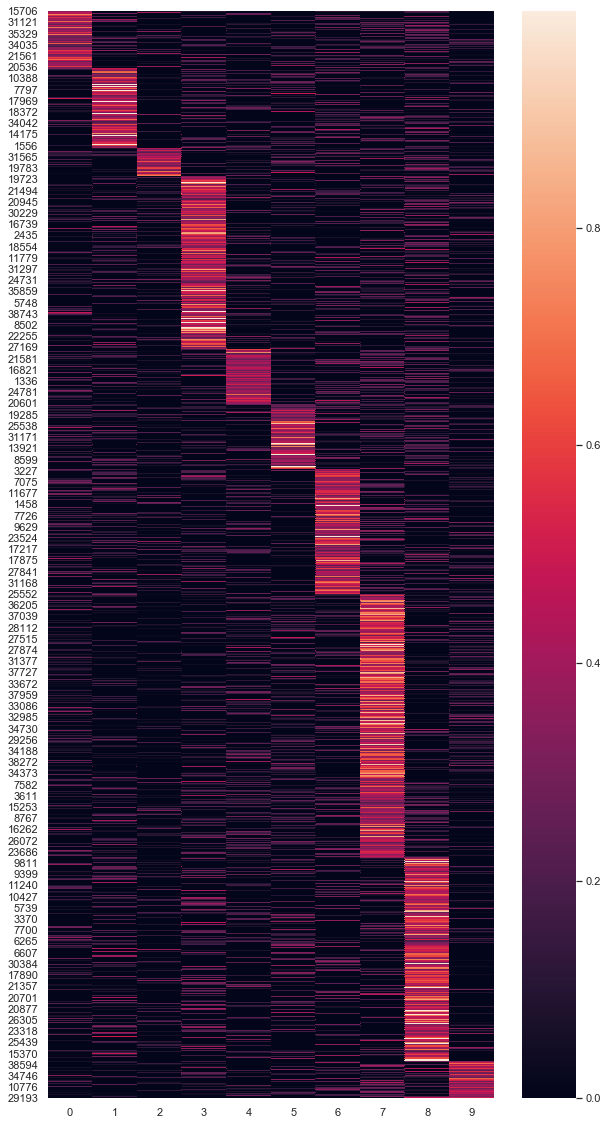

In [70]:
# distribution of topics in all documents

%matplotlib inline
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

Step 4: merging document_topic dataframe back to original dataframe

In [93]:
document_topic['index'] = document_topic.index
data = data.reset_index(drop = True) 
data['index'] = data.index

In [94]:
print(len(document_topic['index'].unique()))
print(len(data['index'].unique()))

38932
38932


In [106]:
merged = data.merge(document_topic, on = 'index')

In [107]:
merged.head(10)

,User_ID,Description,Is_Response,hotel_ID,index,0,1,2,3,4,5,6,7,8,9
0,id10329,Stayed here with husband and sons on the way t...,happy,8,0,0.0,0.935692,0.000000,0.062572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3,1,0.0,0.000000,0.033657,0.047644,0.000000,0.134871,0.782669,0.000000,0.000000,0.000000
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3,2,0.0,0.317652,0.000000,0.307296,0.000000,0.040994,0.081804,0.000000,0.251541,0.000000
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7,3,0.0,0.416078,0.057316,0.000000,0.117221,0.298880,0.000000,0.000000,0.109442,0.000000
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3,4,0.0,0.000000,0.000000,0.671761,0.000000,0.000000,0.000000,0.000000,0.320318,0.000000
5,id10337,"Me, the Wife and - kids stayed here on Valenti...",happy,7,5,0.0,0.684274,0.000000,0.000000,0.000000,0.047181,0.266549,0.000000,0.000000,0.000000
6,id10339,I highly recommend the Hawthorne Terrace as an...,happy,8,6,0.0,0.000000,0.094862,0.386681,0.000000,0.000000,0.331176,0.000000,0.185920,0.000000
7,id10340,I found the hotel clean and nicely located. Go...,happy,3,7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.996413,0.000000,0.000000,0.000000
8,id10341,Stayed at the Elan from --th to --th October a...,happy,1,8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.025408,0.307622,0.579083,0.086725
9,id10344,We stayed here for - nights and were really ha...,happy,5,9,0.0,0.021548,0.279584,0.142681,0.000000,0.031817,0.393010,0.093773,0.000000,0.030788


In [108]:
merged.groupby('hotel_ID').mean()

,index,0,1,2,3,4,5,6,7,8,9
hotel_ID,,,,,,,,,,,
1,21970.108934,0.074110,0.075155,0.043497,0.121297,0.067065,0.078197,0.111221,0.215988,0.148064,0.063614
2,22956.011662,0.074489,0.067372,0.044282,0.119888,0.065730,0.077404,0.109884,0.233160,0.136513,0.069491
3,19429.015545,0.072201,0.085061,0.046547,0.126967,0.070790,0.076706,0.109698,0.181045,0.164769,0.064420
4,19457.661896,0.070060,0.079837,0.046263,0.129042,0.070220,0.078601,0.111958,0.184049,0.166361,0.061821
5,16602.372793,0.073324,0.092849,0.048702,0.140266,0.069971,0.082460,0.109847,0.142351,0.183907,0.054498
6,18771.293863,0.072797,0.079454,0.048013,0.137332,0.073213,0.082944,0.105549,0.175104,0.163584,0.060304
7,21648.918751,0.073300,0.073609,0.043264,0.126248,0.069276,0.074800,0.110443,0.211902,0.149091,0.066326
8,16399.803288,0.069076,0.094340,0.048834,0.141897,0.071678,0.080564,0.106550,0.136784,0.192533,0.055966
9,22659.025100,0.080409,0.070362,0.041127,0.116751,0.066325,0.081490,0.108849,0.221091,0.144031,0.067782


In [ ]:
# the above does not look right, should first do groupby hotel, then come up with 1 topic for all reviews in one hotel